# Replication of plot from actual research article.

With the tutorial you will reproduce two curves from figure 3 panel A of "A novel automated behavioral test battery assessing
cognitive rigidity in two genetic mouse models of autism" (A. Puścian et al.) available at http://www.ncbi.nlm.nih.gov/pmc/articles/PMC4010752/.

## Environment set up
At the beginning download and load into the memory the original data and the experiment timeline config file (see tutorials on basic and advanced topics for details). To save both storage and data transfer time the data has been preprocessed to filter out data unrelated to the research (diagnostic information and data from other research run simultaneously in the system).

_`data`_ and _`timeline`_ are considered to be global variables.

In [1]:
import pymice as pm

pm.getTutorialData(quiet=True)

data = pm.Loader('C57_AB/2012-08-31 11.58.22.zip', getLog=True)

timeline = pm.ExperimentTimeline('C57_AB/timeline.ini')

PyMICE library v. 0.2.2
(NeuroLex.org ID: nlx_158570)

This is a bleeding edge version of the library. It might meet your
expectations, however it might also go to your fridge, drink all the
beer it can find there and then eat your cat. Be warned.



## Period of interest definition

Define a global list of names of subsequent phases.

In [2]:
PHASES = ['NPA 2 dark', 'NPA 2 light',
          'Place Pref 1 dark', 'Place Pref 1 light',
          'Place Pref 2 dark', 'Place Pref 2 light',
          'Place Pref 3 dark', 'Place Pref 3 light']

## Data validation

Check if there was no problems (indicated in log) in the period of our interest.

In [3]:
start, end = timeline.getTime(PHASES)

dataValidator = pm.DataValidator(pm.PresenceLogAnalyzer())
validatorReport = dataValidator(data)

presenceTester = pm.TestMiceData('Presence')
   
if presenceTester(validatorReport, (start, end)):
    print "presences ok"

presences ok


## Data analysis

To calculate an array of performance (fractions of visits to the rewarded corner) define _`getGroupPerformanceArray()`_ function.

To facilitate estimation of animal- and phase-wise performance, values in the array should be assigned to rows by animal and to columns by phase (preferrably in temporal order).

In [4]:
import numpy as np

def getGroupPerformanceArray(groupName):
    group = data.getGroup(groupName)
    performance = [getPerformanceCurve(mouse) \
                   for mouse in group.Animals]
    return np.ma.masked_invalid(performance)

The _`getPerformanceCurve()`_ function returns list of animal's performance values for subsequent phases.

In [5]:
def getPerformanceCurve(mouse):
    correctCorner = getRewardedCorner(mouse)
    return [getPerformance(mouse, phase, correctCorner) \
            for phase in PHASES]

For every mouse the function needs to know, in which corner it was rewarded during "Place Preference" phase. Since the mouse was rewarded in exactly one corner, it is enough to find the first rewarded visit.

In [6]:
def getRewardedCorner(mouse):
    start, end = timeline.getTime('Place Pref 1 dark')
    for visit in data.getVisits(mice=mouse, start=start, end=end):
        if isRewarded(visit):
            return visit.Corner

In the 'Place Preference' phases a visit is rewarded if it is performed to a corner marked for the visiting animal as "correct" ("CornerCondition" attribute of the visit is positive then).

In [7]:
def isRewarded(visit):
    return visit.CornerCondition > 0

You might want to test if the _`getRewardedCorner()`_ function is working.

In [8]:
print "Animal name\tRewarded corner"
for mouse in sorted(data.getMice()):
    print "{}:\t{}".format(mouse, getRewardedCorner(mouse))


Animal name	Rewarded corner
C57 A 1:	1
C57 A 10:	4
C57 A 11:	4
C57 A 2:	1
C57 A 3:	1
C57 A 4:	2
C57 A 5:	2
C57 A 6:	2
C57 A 7:	3
C57 A 8:	3
C57 A 9:	3
C57 B 1:	1
C57 B 10:	4
C57 B 11:	4
C57 B 12:	4
C57 B 2:	1
C57 B 3:	1
C57 B 4:	2
C57 B 5:	2
C57 B 6:	2
C57 B 7:	None
C57 B 8:	None
C57 B 9:	3


The simplest way to calculate the performance is to calculate fraction of visits to the rewarded corner.

Since _`True`_ and _`False`_ are interpreted by _`numpy`_ as _`0`_ and _`1`_, respectively, the frection is equal to the mean of boolean values indicating whether visit was to rewarded corner or not. If there was no visit, the mean would be not-a-number (_`nan`_) and a warning would be reported.

In [9]:
def getPerformance(mouse, phase, rewardedCorner):
    start, end = timeline.getTime(phase)
    visits = data.getVisits(mice=mouse, start=start, end=end)
    toRewardedCorner = [visit.Corner is rewardedCorner for visit in visits]
    return np.mean(toRewardedCorner)

## Results visualisation (details)

** Stuff covered in this section might be important mainly for you if you want to improve your Python programminng skills. **

Declare a function _`plotAverages()`_ for plotting summary of mice's performance. Yes, WE DO KNOW that you should use 95% CI for error bars instead of SEM, but you are going to reconstruct an actual plot, are not you?

In [10]:
def plotAverages(ax, x, ys, color, label):
    mean = ys.mean(axis=0)
    sem = ys.std(axis=0) / np.sqrt(np.logical_not(ys.mask).sum(axis=0))

    ax.errorbar(x, mean * 100, yerr=sem * 100,
                color=color, markeredgecolor=color,
                label=label,               
                linewidth=3, linestyle='--',
                elinewidth=2, ecolor="black",
                marker='o', markersize=10,
                dash_capstyle='round',
                alpha=0.69)

Define a context manager class _`DecoratedAxes`_ providing you with a preprocessed _`matplotlib.axes.Axes`_ object and taking care for details like providing legend after the plotting is finished.

In [11]:
import matplotlib.pyplot as plt
import matplotlib.dates as mpd
import matplotlib.ticker as mtick

import pytz

CET = pytz.timezone('CET')

class DecoratedAxes(object):
    def __enter__(self):
        self.fig, ax = plt.subplots(figsize=(13, 8))
        self.ax = ax

        ax.set_title('C57BL/6 - PLACE PREFERENCE LEARNING')
        
        ax.set_ylim(0, 70)
        ax.set_ylabel('% of visits to sugar corner')
        ax.yaxis.set_major_formatter(mtick.FormatStrFormatter("%.0f%%"))

        for i in range(10, 70, 10):
            ax.axhline(i, color='#A0A0A0', lw=1)
        
        ax.set_xlim(getTimeBounds(PHASES))
        ax.set_xlabel('experiment phase')
        ax.set_xticks(map(getPhaseMidtime, PHASES))
        ax.xaxis.set_major_formatter(timeline)

        for phase in PHASES:
            if phase.endswith('dark'):
                start, end = getTimeBounds(phase)
                ax.axvspan(start, end, color='#E0E0E0')

        return ax

    def __exit__(self, type, value, traceback):
        self.ax.legend(loc='lower right')
        self.ax.autoscale_view()
        self.fig.autofmt_xdate()

To have the contest manager working you need to define two auxilary functions. The first one is _`getTimeBounds()`_ which converts name(s) of phase(s) into pair of its/theirs boundaries in _`matplotlib.dates`_ reference space.

The second one - _`getPhaseMidtime()`_ - converts phase name to its midpoint in the mentioned reference space.

In [12]:
def getTimeBounds(phases):
    return mpd.date2num(timeline.getTime(phases))
    
def getPhaseMidtime(phase):
    return getTimeBounds(phase).mean()

## Plot reproduction

Combine all written code together and plot the results.

%matplotlib magic command is for purpose of the ipython notebook only.

/home/jkowalski/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/jkowalski/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:71: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


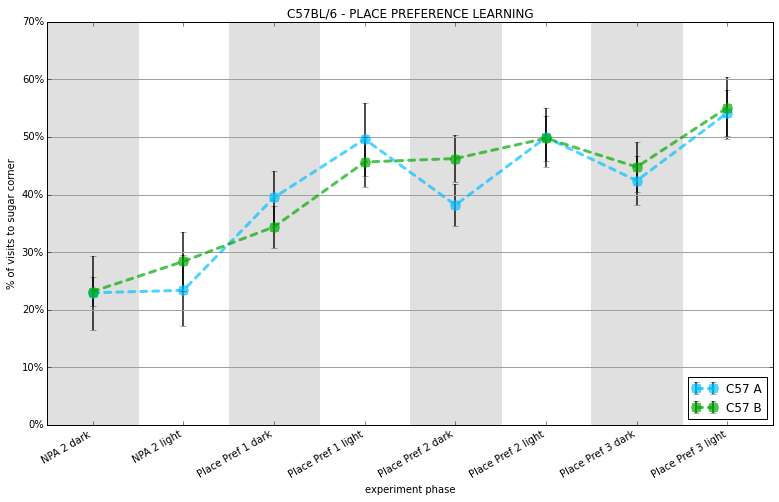

In [13]:
%matplotlib inline

with DecoratedAxes() as ax:
    for groupName, color in [('C57 A', '#00c0ff'),
                             ('C57 B', '#00aa00'),]:
        plotAverages(ax, map(getPhaseMidtime, PHASES),
                         getGroupPerformanceArray(groupName),
                         color, groupName)
#plt.show()